In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import ipyvolume as ipv
import pathlib, glob
from scipy.stats import norm
import time
import mrcfile

In [3]:
import sys
sys.path.append('../src/')
from forward_modeling import project_volume, rotate_volume, take_slice, project_volume_fst, backprojection, add_slice, create_circular_mask, fft, ifft
from scipy.interpolate import RegularGridInterpolator, griddata

Make sure we have a local directory to read the data from, and that the data is there

In [4]:
data_directory = pathlib.Path('..') / 'data'  # directory where the data is
output_dir = data_directory / 'test'
if output_dir.exists():
    print(f'Data directory {output_dir} exists: ')
    for x in list(output_dir.glob('*')):
        print(f'>>> {str(x)}') 

Data directory ../data/test exists: 
>>> ../data/test/particle_hires_xyz.npy
>>> ../data/test/particle_oddres_meta.npy
>>> ../data/test/particle_hires_map.npy
>>> ../data/test/.DS_Store
>>> ../data/test/particle_meta.npy
>>> ../data/test/het_particle_meta.npy
>>> ../data/test/particle_hires_data.npy
>>> ../data/test/particle_hires_meta.npy
>>> ../data/test/particle_map.npy
>>> ../data/test/particle_oddres_data.npy
>>> ../data/test/particle_xyz.npy
>>> ../data/test/particle_oddres_map.npy
>>> ../data/test/het_particle_data.npy
>>> ../data/test/particle_oddres_xyz.npy
>>> ../data/test/het_particle_map.npy
>>> ../data/test/particle_data.npy


Pick a dataset by its keyword

In [5]:
keyword='particle_oddres'
dataset     = np.load(f'{output_dir}/{keyword}_data.npy')
metadataset = np.load(f'{output_dir}/{keyword}_meta.npy')
volume      = np.load(f'{output_dir}/{keyword}_map.npy')
structure   = np.load(f'{output_dir}/{keyword}_xyz.npy')

Let's have a look at the structure

In [6]:
ipv.quickscatter(structure[:,0], structure[:,1], structure[:,2], size=10*structure[:,3], marker='sphere')

Now let's check the volume

In [56]:
ipv.quickvolshow(volume, level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

/Users/michaelresplandy/miniconda3/envs/gmm-cryoem/lib/python3.6/site-packages/ipyvolume/serialize.py:92: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0] ** 2 + gradient[1] ** 2 + gradient[2] ** 2)


And now a few of the projection images

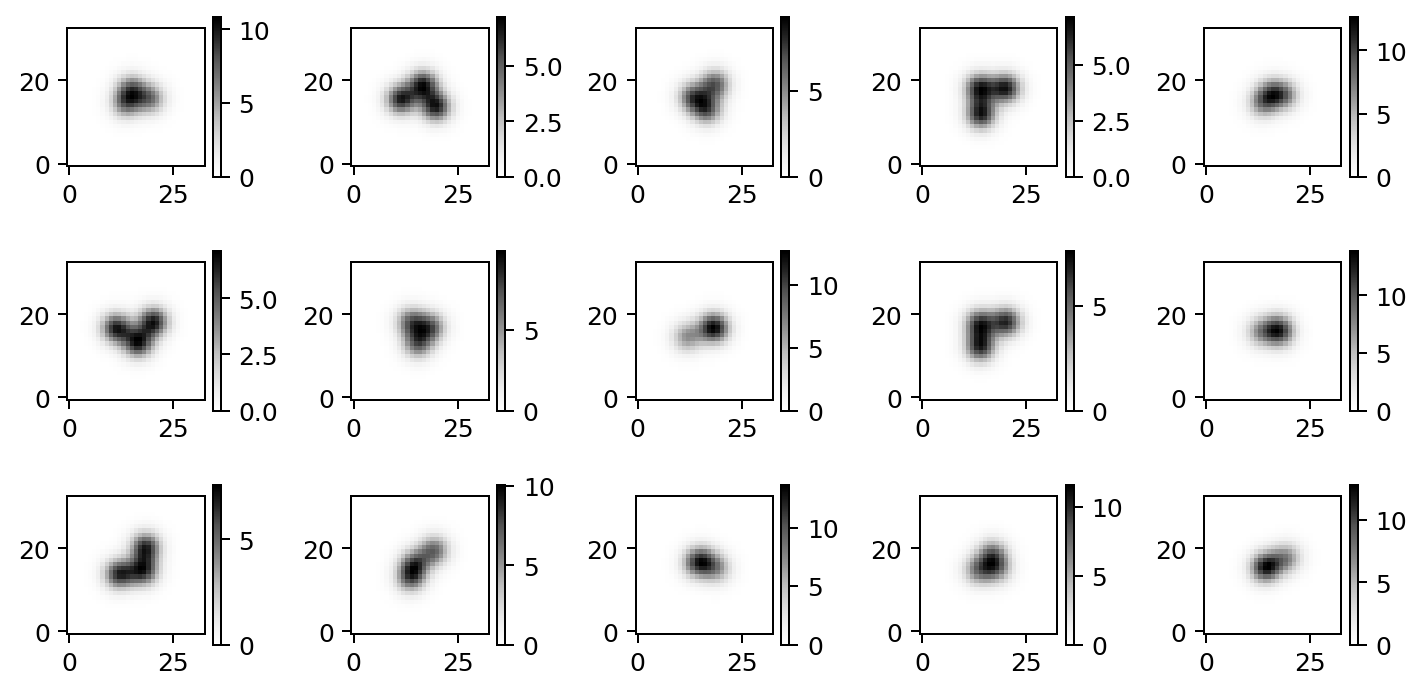

In [8]:
nrows=3
ncols=5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,4), dpi=180)
k=0
for i in np.arange(nrows):
    for j in np.arange(ncols):
        #axes[i,j].plot(metadataset[k,0:3])
        ax = axes[i,j]
        ims = ax.imshow(dataset[k], cmap='Greys', origin='lower')
        fig.colorbar(ims, ax=ax)
        k+=1
plt.tight_layout()
plt.show()

# Projections
We now look into projections where instead of rotating the particle, we rotate the slicing plane

time: 0.018496990203857422, sum of pixels: 792.6919279508109, mse: 0.00048379221338117057
time: 0.0015549659729003906, sum of pixels: 792.6914147189545, mse: 0.03084904723620321
sum of pixels for real projection: 792.7008855110696


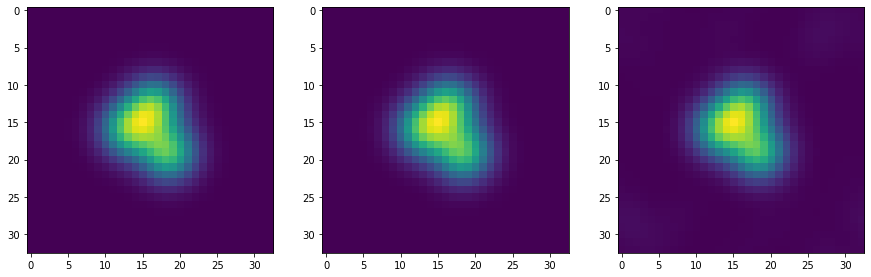

In [6]:
keyword='particle_oddres'
dataset     = np.load(f'{output_dir}/{keyword}_data.npy')
metadataset = np.load(f'{output_dir}/{keyword}_meta.npy')
volume      = np.load(f'{output_dir}/{keyword}_map.npy')
structure   = np.load(f'{output_dir}/{keyword}_xyz.npy')

i=2
Rot = R.from_rotvec(-metadataset[i,0:3])
start1 = time.time()
projection = project_volume(volume, Rot)
end1 = time.time()
print(f"time: {end1-start1}, sum of pixels: {np.sum(projection)}, mse: {np.mean(np.power(projection-dataset[i], 2))}")

volume_ft = fft(volume)

start2 = time.time()
projection_fst = project_volume_fst(volume_ft, Rot, mask_radius = 100)
end2 = time.time()
print(f"time: {end2-start2}, sum of pixels: {np.sum(projection_fst)}, mse: {np.mean(np.power(projection_fst-dataset[i], 2))}")

fig, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].imshow(dataset[i])
ax[1].imshow(projection)
ax[2].imshow(projection_fst)

print(f"sum of pixels for real projection: {np.sum(dataset[i])}")

plt.show()

Here we plot from the left to the right:
- The projection as given in the dataset
- The projection obtained using our projection function (rotating the volume in real space and then projecting along the z-axis)
- The projection obtained using the slice-projection theorem


# Backprojection with known orientations


In [57]:
keyword='particle'
dataset     = np.load(f'{output_dir}/{keyword}_data.npy')
metadataset = np.load(f'{output_dir}/{keyword}_meta.npy')
volume      = np.load(f'{output_dir}/{keyword}_map.npy')
structure   = np.load(f'{output_dir}/{keyword}_xyz.npy')


start = time.time()
#vol_part_reconstructed = backprojection(dataset[90:100], metadataset[90:100,0:3])
vol_reconstructed = backprojection(dataset[:100], metadataset[:100,0:3])
#vol_reconstructed = backprojection_bis(dataset[:100], metadataset[:100,0:3])
end = time.time()
print(f"time: {end-start}, sum of voxels: {np.sum(vol_reconstructed)}")
print(f"sum of voxels for real volume: {np.sum(volume)}")
print(f"mean squared error: {(np.mean(np.power(volume-vol_reconstructed, 2)))}")

ipv.quickvolshow((volume), level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

time: 0.30232977867126465, sum of voxels: 563.0867450166818
sum of voxels for real volume: 720.6748632877983
mean squared error: 0.0007920113888524852


In [58]:
ipv.quickvolshow((vol_reconstructed), level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

In [64]:
keyword='particle_oddres'
dataset     = np.load(f'{output_dir}/{keyword}_data.npy')
metadataset = np.load(f'{output_dir}/{keyword}_meta.npy')
volume      = np.load(f'{output_dir}/{keyword}_map.npy')
structure   = np.load(f'{output_dir}/{keyword}_xyz.npy')


start = time.time()
#vol_part_reconstructed = backprojection(dataset[90:100], metadataset[90:100,0:3])
vol_reconstructed = backprojection(dataset[:100], metadataset[:100,0:3])
#vol_reconstructed = backprojection_bis(dataset[:100], metadataset[:100,0:3])
end = time.time()
print(f"time: {end-start}, sum of voxels: {np.sum(vol_reconstructed)}")
print(f"sum of voxels for real volume: {np.sum(volume)}")
print(f"mean squared error: {(np.mean(np.power(volume-vol_reconstructed, 2)))}")

ipv.quickvolshow((volume[:-1,:-1,:-1]), level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

time: 0.33090925216674805, sum of voxels: 792.7007865791751
sum of voxels for real volume: 792.6914147189551
mean squared error: 5.698637872276155e-05


In [63]:
ipv.quickvolshow((vol_reconstructed[:-1,:-1,:-1]), level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

# Backprojection with unknown orientations

The backprojection works differently when the orientations aren't known. We need:
- a reference volume that we will project in a set of orientations (taken as uniformly as possible).
- a scoring function (named "proba" here) that will tell how close to images are, that we'll use to tell how probable an image comes from a specific projection. 

The algorithm works then by adding each image of the dataset in each direction of our set of orientations, weighed by this score.

In [39]:
def proba(projected_vol, image, scale=10):
    """
    This function calculates a probability score to tell how close two images are.
    """
    return np.prod((1-norm.cdf(np.abs(projected_vol-image), loc=0, scale=scale))*2)

def reconstruct(dataset, vols, quat_count, heterogeneity = False, input_is_ft = False, output_is_ft = False):
    """
    This function reconstructs the models at step t+1 given the models at step t
    To long, mainly because of the projection operator
    """
    x1s = np.linspace(0,1,quat_count)
    x2s = np.linspace(-1,1,quat_count)
    x3s = np.linspace(-1,1,quat_count)
    x4s = np.linspace(-1,1,quat_count)
    
    if not(input_is_ft):
        if (heterogeneity):
            for k in range(vols.shape[0]):
                vols[k] = fft(vols[k])

        else:
            vols = fft(vols)
        
    counts = np.zeros(vols.shape, dtype=complex)
    next_models = np.zeros(vols.shape, dtype=complex)

    #Sampling of SO3 (set of 3d rotations)
    for x1 in x1s:
        for x2 in x2s:
            for x3 in x3s: 
                for x4 in x4s:
                    quat = np.array((x1,x2,x3,x4))
                    if np.sum(np.abs(quat)) != 0:
                        rot = R.from_quat(quat)
                        
                        
                        for i in range(len(dataset)):
                            images_i = fft(dataset[i])
                            
                            #Adding the i-th slice in the "rot"-rotated plane weighed by the similarity score 
                            if heterogeneity:      
                                for k in range(vols.shape[0]):
                                    projected_vol = project_volume_fst(vols[k], rot)
                                    prob = proba(projected_vol, dataset[i])
                                    next_models[k], counts[k] = add_slice(next_models[k], counts[k], images_i, rot,prob = prob) 
                                    #we add the image, weighed by the probabity
                                    #to construct the models at the next iteration
                            else:
                                projected_vol = project_volume_fst(vols, rot)
                                prob = proba(projected_vol, dataset[i])                                      
                                #probs+= prob
                                next_models, counts = add_slice(next_models, counts, images_i, rot, prob = prob)

    counts[counts == 0] = 1
    
    #Dividing by count to scale the solution/ taking the inverse fourier transform
    if (heterogeneity):
        for k in range(vols.shape[0]):
            next_models[k] = next_models[k]/counts[k]
            if not(output_is_ft):
                next_models[k] = np.real(ifft(next_models[k]))
                                                        
    else:
        next_models = next_models/counts
        if not(output_is_ft):
                next_models = np.real(ifft(next_models))
        
    return next_models 

In [46]:
keyword='particle_oddres'
dataset     = np.load(f'{output_dir}/{keyword}_data.npy')
metadataset = np.load(f'{output_dir}/{keyword}_meta.npy')
volume      = np.load(f'{output_dir}/{keyword}_map.npy')
structure   = np.load(f'{output_dir}/{keyword}_xyz.npy')

start = time.time()
vol_init = backprojection(dataset[:5], metadataset[:5,0:3]) #initial volume

vol2 = reconstruct(dataset[:100], vol_init, quat_count = 4)
end = time.time()

In [47]:
print(f"time: {end-start}, sum of voxels before: {np.sum(vol_init)}, sum of voxels after: {np.sum(vol2)}")
print(f"mean squared error: {(np.mean(np.power(volume-vol_init, 2)))}")
print(f"mean squared error: {(np.mean(np.power(volume-vol2, 2)))}")

time: 108.61249113082886, sum of voxels before: 792.7008298862398, sum of voxels after: 792.700806825441
mean squared error: 0.0010661462585326166
mean squared error: 0.00038032407784144404


In [65]:
ipv.quickvolshow(vol_init.real, level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

In [32]:
ipv.quickvolshow(vol2, level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

# Full reconstruction with Expectation Maximization

In [52]:
def EM(dataset, models_init, eps=1, n_steps=10, quat_count=4, heterogeneity = False):
    """
    This function iterates the reconstruct function to converge to a local optimum
    """
    models = models_init
    if heterogeneity:
        for k in range(models.shape[0]):
            models[k] = fft(models[k])
    else:
        models = fft(models)
        
    step = 0
    end = False
    while step<n_steps and not(end):
        print('step:' +str(step+1))
        next_models = reconstruct(dataset, models, quat_count, input_is_ft=True, output_is_ft=True)
        step +=1
        if np.mean(np.power(next_models - models, 2)) < eps:
            end = True
            print("FINISHED EARLY")
        models = next_models
        print(f"mean squared error: {(np.mean(np.power(volume-ifft(models).real, 2)))}")
        print('loglikelihood')

    
    return ifft(models).real

In [53]:
keyword='particle_oddres'
dataset     = np.load(f'{output_dir}/{keyword}_data.npy')
metadataset = np.load(f'{output_dir}/{keyword}_meta.npy')
volume      = np.load(f'{output_dir}/{keyword}_map.npy')
structure   = np.load(f'{output_dir}/{keyword}_xyz.npy')

In [54]:
start = time.time()
vol_init = backprojection(dataset[:5], metadataset[:5,0:3]) #initial volume
vol_final = EM(dataset[:100], vol_init, eps =1e-6, n_steps=5)
end = time.time()

step:1
mean squared error: 0.00038032407784144404
step:2
mean squared error: 0.0003671675503803466
step:3
mean squared error: 0.0004230056865187904
step:4
mean squared error: 0.00046352132379200785
step:5
mean squared error: 0.00048650978422498317


In [55]:
print(f"time: {end-start}, sum of voxels before: {np.sum(vol_init)}, sum of voxels after: {np.sum(vol_final)}")
print(f"mean squared error: {(np.mean(np.power(volume-vol_init, 2)))}")
print(f"mean squared error: {(np.mean(np.power(volume-vol_final, 2)))}")

time: 511.017924785614, sum of voxels before: 792.7008298862398, sum of voxels after: 792.7006769522535
mean squared error: 0.0010661462585326166
mean squared error: 0.00048650978422498317


In [37]:
ipv.quickvolshow(vol_init, level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

In [38]:
ipv.quickvolshow(vol_final, level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

# With a real dataset

In [22]:
data_directory = pathlib.Path('..') / 'data'  # directory where the data is
map_dir = data_directory / 'EMPIAR' / '10077'

id = 4121
fname = f'emd_{id}.map.gz'


with mrcfile.open(f'{str(map_dir)}/{fname}') as mrc:
    real_volume = mrc.data
print(f'> Loaded map of shape: {volume.shape}')

> Loaded map of shape: (272, 272, 272)


time: 14.182299852371216, sum of pixels: 339731.2670283999
time: 0.3272402286529541, sum of pixels: 305755.46803136513
time: 13.771414995193481, sum of pixels: 334053.2245268929
time: 0.2811899185180664, sum of pixels: 305755.46803136496
time: 13.704125881195068, sum of pixels: 329827.11047224613
time: 0.3272402286529541, sum of pixels: 305755.46803136496


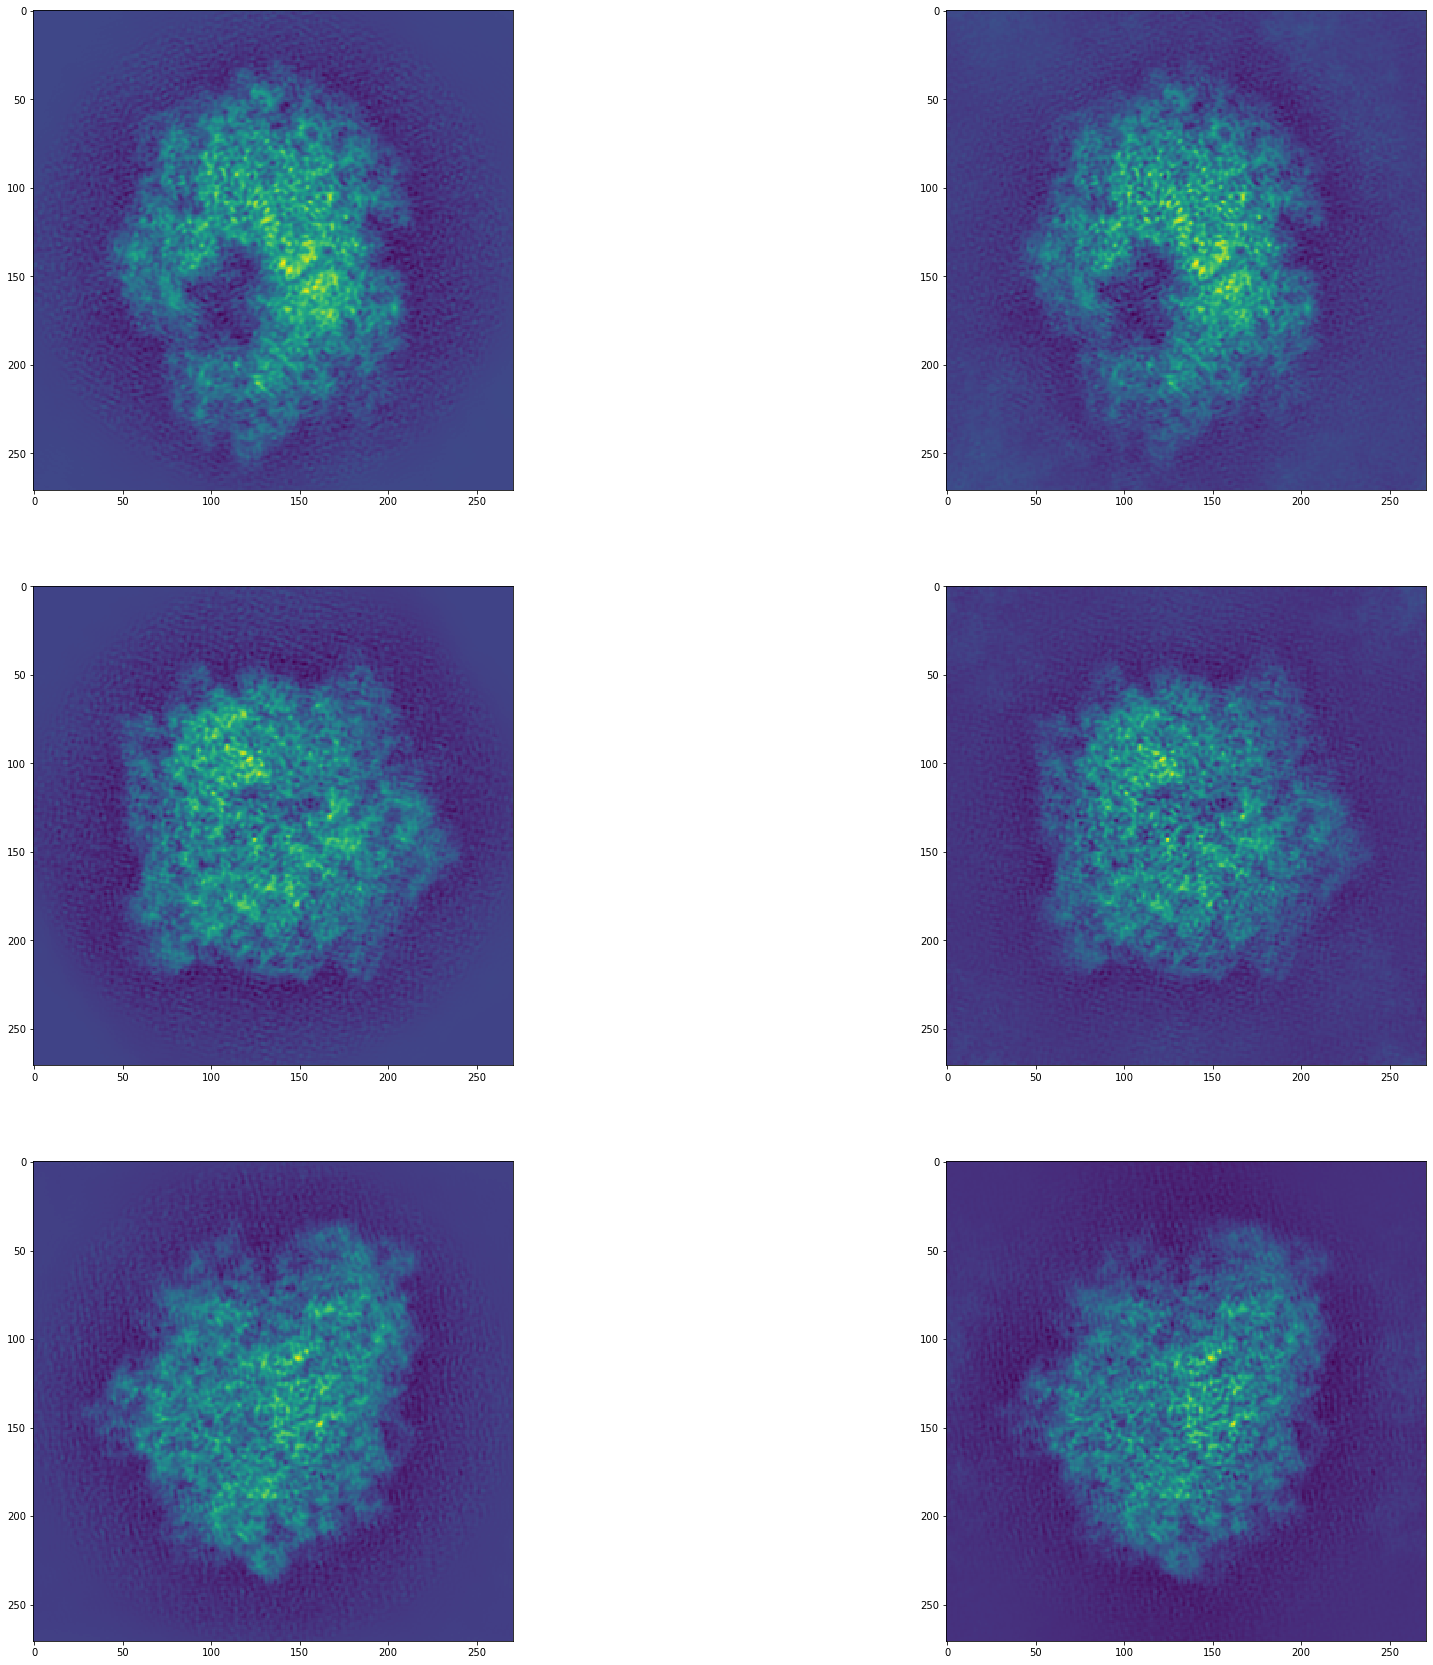

In [23]:
volume_odd = real_volume[:-1,:-1,:-1]
volume_odd_ft = fft(volume_odd)

i=2
Rot = R.from_rotvec(-metadataset[i,0:3])
start1 = time.time()
projection1 = project_volume(volume_odd, Rot)
end1 = time.time()
print(f"time: {end1-start1}, sum of pixels: {np.sum(projection1)}")

start2 = time.time()
projection_fst2 = project_volume_fst(volume_odd_ft, Rot, mask_radius = 100)
end2 = time.time()
print(f"time: {end2-start2}, sum of pixels: {np.sum(projection_fst2)}")

i=5
Rot = R.from_rotvec(-metadataset[i,0:3])
start3 = time.time()
projection3 = project_volume(volume_odd, Rot)
end3 = time.time()
print(f"time: {end3-start3}, sum of pixels: {np.sum(projection3)}")

start4 = time.time()
projection_fst4 = project_volume_fst(volume_odd_ft, Rot, mask_radius = 100)
end4 = time.time()
print(f"time: {end4-start4}, sum of pixels: {np.sum(projection_fst4)}")

i=9
Rot = R.from_rotvec(-metadataset[i,0:3])
start5 = time.time()
projection5 = project_volume(volume_odd, Rot)
end5 = time.time()
print(f"time: {end5-start5}, sum of pixels: {np.sum(projection5)}")

start6 = time.time()
projection_fst6 = project_volume_fst(volume_odd_ft, Rot, mask_radius = 100)
end6 = time.time()
print(f"time: {end2-start2}, sum of pixels: {np.sum(projection_fst6)}")

fig, ax = plt.subplots(3, 2, figsize=(30,30))
ax[0,0].imshow(projection1)
ax[0,1].imshow(projection_fst2)
ax[1,0].imshow(projection3)
ax[1,1].imshow(projection_fst4)
ax[2,0].imshow(projection5)
ax[2,1].imshow(projection_fst6)

plt.show()